# TPS 2022-09 - PyCaret3 AutoML Classification

- https://pycaret.org/

> PyCaret is an open-source, low-code machine learning library in Python that aims to reduce the cycle time from hypothesis to insights. It is well suited for seasoned data scientists who want to increase the productivity of their ML experiments by using PyCaret in their workflows or for citizen data scientists and those new to data science with little or no background in coding. PyCaret allows you to go from preparing your data to deploying your model within seconds using your choice of notebook environment.

This notebook is part of a series using PyCaret to create baseline AutoML predictions

In [1]:
%%html
<style> 
table { float:left; margin-bottom: 1em; } 
table + * { content: ""; clear: both; display: table; }
iframe { height: 550em; }
</style>

In [2]:
%%time
# BUGFIX: https://github.com/pycaret/pycaret/issues/2837#issuecomment-1217630148
!pip install --pre pycaret[full] -q 2> /dev/null
!pip install autoviz tune-sklearn ray[tune] scikit-optimize hyperopt optuna hpbandster ConfigSpace -q 2> /dev/null

CPU times: user 2.58 s, sys: 378 ms, total: 2.96 s
Wall time: 2min 5s


In [3]:
from pycaret.utils import version
version()

'3.0.0.rc3'

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib
import pycaret
import pycaret.regression

%matplotlib inline

pd.set_option('display.max_rows',    10)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width',       1000)

In [5]:
# os.environ["KAGGLE_KERNEL_RUN_TYPE"] = "Interactive"  # Quickrun for Debugging

# Custom Metric
- https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/overview/evaluation
- https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

NOTE: using inbuilt MAPE instead

In [6]:
# def SMAPE(y_true, y_pred):
#     denominator = (y_true + np.abs(y_pred)) / 200.0
#     diff = np.abs(y_true - y_pred) / denominator
#     diff[denominator == 0] = 0.0
#     return np.mean(diff)

# try: add_metric('smape', 'SMAPE', SMAPE, greater_is_better=False)
# except: pass

# Load Dataset

- https://pycaret.readthedocs.io/en/latest/api/datasets.html?highlight=get_data#pycaret.datasets.get_data

> All modules in PyCaret can work directly with pandas Dataframe. It can consume the dataframe, Irrespective of how it is loaded in the environment. See the below example of loading a csv file into the notebook using pandas native functionality.
>
> PyCaret also hosts the repository of open source datasets that were used throughout the documentation for demonstration purposes. These are hosted on PyCaret’s github and can also be directly loaded using `pycaret.datasets module`


In [7]:
# Source: https://www.kaggle.com/code/jamesmcguigan/tps-2022-09-profilereport-autoeda/
def enhance_types(df):
    for col in df:
        if len(np.unique(df[col])) <= 10:
            df[col] = df[col].astype('category')                    
    
    for col in ['date']:
        df[col] =  pd.to_datetime(df[col], format='%Y-%m-%d')

    return df
  
def enhance_features(df):
    ### PyCaret does this internally already    
    # for col in ['date']:    
    #     train_df[f'{col}_day']   = train_df[col].dt.day
    #     train_df[f'{col}_month'] = train_df[col].dt.month
    #     train_df[f'{col}_year']  = train_df[col].dt.year
    return df
    
def enhance(df):
    df = enhance_types(df)
    df = enhance_features(df)
    return df

In [8]:
# # Source: https://www.kaggle.com/code/jamesmcguigan/tps-2022-09-profilereport-autoeda/

# def enhance_types(df):
#     for col in df:
#         if len(np.unique(df[col])) <= 10:
#             df[col] = df[col].astype('category')                    
    
#     for col in ['date']:
#         df[col] =  pd.to_datetime(df[col], format='%Y-%m-%d')

#     return df


# def enhance_features(df):
#     # Manual Feature Engineering Ratios: 
#     # IDEA: https://www.kaggle.com/competitions/tabular-playground-series-sep-2022/discussion/349941
#     # DOCS: https://stackoverflow.com/questions/12200693/python-pandas-how-to-assign-groupby-operation-results-back-to-columns-in-parent
#     col_order = {
#         "original":  [ 'date', 'country',  'store', 'product'],
#         "col_ratio": [],        
#         "col_total": [],
#     }
#     col_groups = [
#         ['date', 'country'],
#         ['date', 'store'],
#         ['date', 'product'],
#         ['date', 'country', 'store'],
#         ['date', 'country', 'product'],
#         ['date', 'store',   'product'],
#         # [ 'date', 'country',  'store', 'product'],  # This is the entire column
#     ]
#     for col_group in col_groups:
#         col_total = "_".join(col_group) + '_sold'
#         col_ratio = "_".join(col_group) + '_ratio'        
#         col_order['col_total'] += [col_total]
#         col_order['col_ratio'] += [col_ratio]
#         df[col_total] = df.groupby(col_group)['num_sold'].transform('sum')
#         df[col_ratio] = df['num_sold'] / df[col_total]        
#         del df[col_total]  # Remove totals columns

#     # Reorder Columns
#     col_order['original'] = [ 
#         col 
#         for col in df.columns 
#         if  col not in col_order['col_total'] 
#         and col not in col_order['col_ratio']
#     ]
#     df = df.reindex(columns=col_order['original'] + col_order['col_ratio'])
#     return df
    
    
# def enhance(df):
#     df = enhance_types(df)
#     df = enhance_features(df)
#     return df

In [9]:
index_col  = 'row_id'
target_col = 'num_sold'
train_df   = pd.read_csv('../input/tabular-playground-series-sep-2022/train.csv', index_col=index_col)
train_df   = enhance(train_df)

In [10]:
train_df

,date,country,store,product,num_sold
row_id,,,,,
0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240
...,...,...,...,...,...
70123,2020-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,614
70124,2020-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,215
70125,2020-12-31,Spain,KaggleRama,Kaggle Getting Started,158


In [11]:
display(train_df.dtypes)
display(train_df)
display(train_df.describe().T)
display(pd.DataFrame([{
    col: len(np.unique(train_df[col]))
    for col in train_df
}], index=['unique_values']))

date        datetime64[ns]
country           category
store             category
product           category
num_sold             int64
dtype: object

,date,country,store,product,num_sold
row_id,,,,,
0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240
...,...,...,...,...,...
70123,2020-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,614
70124,2020-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,215
70125,2020-12-31,Spain,KaggleRama,Kaggle Getting Started,158


,count,mean,std,min,25%,50%,75%,max
num_sold,70128.0,194.296986,126.893874,19.0,95.0,148.0,283.0,986.0


,date,country,store,product,num_sold
unique_values,1461,6,2,4,699


# Initialize Setup

- https://pycaret.gitbook.io/docs/get-started/functions/initialize
- https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=setup#pycaret.classification.setup

> Depending on the type of experiment you want to perform, one of the six available modules currently supported must be imported in your python environment. Importing a module prepares an environment for specific task. For example, if you have imported the Classification module, the environment will be setup accordingly to perform classification tasks only. 

| S.No	| Module	| How to Import |
|-------|:----------|:--------------|
| 1		| Classification				| from pycaret.classification import * |
| 2		| Regression					| from pycaret.regression import * |
| 3		| Clustering					| from pycaret.clustering import * |
| 4		| Anomaly Detection				| from pycaret.anomaly import * |
| 5		| Natural Language Processing	| from pycaret.nlp import * |
| 6		| Association Rule Mining		| from pycaret.arules import * |


> Note: If you don’t want PyCaret to display the dialogue for confirmation of data types you may pass silent as True within setup to perform a unattended run of experiment. We don’t recommend that unless you are absolutely sure the inference is correct or you have performed the experiment before or you are overwriting data types using numeric_feature and categorical_feature parameter.

# setup()
- https://pycaret.readthedocs.io/en/latest/api/classification.html?#pycaret.classification.setup

In [12]:
from pycaret.regression import *
import tensorflow as tf

In [13]:
%%time
setup(
    train_df, 
    target='num_sold',
    
    ### Config
    experiment_name='tabular-playground-2022-09',
    use_gpu=tf.test.is_gpu_available(),
    session_id=42,
    
    
    ### Logging + Display
    profile=True,   
    log_experiment=False, 
    log_plots=True,
    html=True,
    verbose=True,
    
    ### Settings
    max_encoding_ohe=0,  # Always one-hot-encode categorical columns
    
    
    ### Feature Engineering 
    # imputation_type='iterative', iterative_imputation_iters=10, # too much memory ???
    # numeric_imputation=0, # 'knn',
    # fix_imbalance=True,
    # normalize=True,      normalize_method='zscore',            # zscore | minmax | maxabs | robust
    # transformation=True, transformation_method='yeo-johnson',  # yeo-johnson | quantile
    # feature_interaction=True,    # BUG: Not implemented
    # feature_ratio=True,          # BUG: Not implemented
    # trigonometry_features=True,  # BUG: Not implemented    
    # combine_rare_levels=True,    # BUG: Not implemented
    # create_clusters=True,        # BUG: Not implemented
    
    
    ### Feature Selection    
    # remove_outliers=True,           # IGNORE: Keep as we are predicting failures    
    # remove_multicollinearity=True,    # BUG: IndexError: single positional indexer is out-of-bounds
    # ignore_low_variance=True,       # BUG: Not implemented
    
    
    ### PCA Column Engineering
    # polynomial_features=True,            # WORKS: Uses too much memory        
    # pca=True, pca_method="incremental",  # linear | incremental | kernel
    # feature_selection=True, n_features_to_select=20,
)

,Description,Value
0,Session id,42
1,Target,num_sold
2,Target type,Regression
3,Data shape,"(70128, 7)"
4,Train data shape,"(49089, 7)"
5,Test data shape,"(21039, 7)"
6,Ordinal features,1
7,Date features,1
8,Categorical features,3
9,Preprocess,True


Loading profile... Please Wait!
CPU times: user 16.9 s, sys: 422 ms, total: 17.4 s
Wall time: 18.5 s


# AutoEDA - pandas_profiling.ProfileReport

EDA in standalone notebook: 
- https://www.kaggle.com/code/jamesmcguigan/tps-2022-09-profilereport-autoeda 

# Compare Baseline

- https://pycaret.gitbook.io/docs/get-started/functions/train#compare_models
- https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=compare_models#pycaret.classification.compare_models

> This is the first step we recommend in the workflow of any supervised experiment. This function trains all the models in the model library using default hyperparameters and evaluates performance metrics using cross-validation. It returns the trained model object. 

In [14]:
def model_classname_str(model): 
    return str(model.__class__).split("'")[1].split('.')[-1]    

In [15]:
%%time
models_compared = compare_models(
    fold     = 5 if os.environ.get('KAGGLE_KERNEL_RUN_TYPE') == 'Batch' else 3, 
    n_select = 3, 
    sort     = 'mape',
    # fit_kwargs = { 'silent': True }  # BUG: breaks n_select=5
)

# BUGFIX: models_compared is a list
models = {}
for model in models_compared: 
    name = model_classname_str(model)
    models[name] = model

models

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,31.8367,2462.2632,49.6176,0.8482,0.2301,0.1860,2.1820
huber,Huber Regressor,46.2686,4134.2599,64.1877,0.7451,0.4050,0.3030,0.8100
lasso,Lasso Regression,43.6481,3501.0200,59.1679,0.7841,0.4601,0.3163,0.7060
lr,Linear Regression,43.6985,3496.5051,59.1298,0.7844,0.5015,0.3199,2.6700
ridge,Ridge Regression,43.6982,3496.5051,59.1298,0.7844,0.5015,0.3199,0.5960
lar,Least Angle Regression,43.6985,3496.5051,59.1298,0.7844,0.5015,0.3199,0.6040
br,Bayesian Ridge,43.6983,3496.5051,59.1298,0.7844,0.5015,0.3199,0.5980
catboost,CatBoost Regressor,48.9718,4230.8956,65.0136,0.7391,0.3520,0.3299,8.4020
knn,K Neighbors Regressor,47.8612,4139.2462,64.2330,0.7448,0.3583,0.3332,0.7480
omp,Orthogonal Matching Pursuit,62.2324,7220.9670,84.9752,0.5548,0.4551,0.4445,0.5940


Processing:   0%|          | 0/87 [00:00<?, ?it/s]

CPU times: user 23.6 s, sys: 2.7 s, total: 26.3 s
Wall time: 2min 57s


{'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
 'HuberRegressor': HuberRegressor(),
 'Lasso': Lasso(random_state=42)}

# Create Models

- https://pycaret.gitbook.io/docs/get-started/functions/train#create_model
- https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=create_model#pycaret.classification.create_model

> Creating a model in any module is as simple as writing create_model. It takes only one parameter i.e. the Model ID as a string. For supervised modules (classification and regression) this function returns a table with k-fold cross validated performance metrics along with the trained model object. For unsupervised module For unsupervised module clustering, it returns performance metrics along with trained model object and for remaining unsupervised modules anomaly detection, natural language processing and association rule mining, it only returns trained model object. The evaluation metrics used are:
>
> - Classification: Accuracy, AUC, Recall, Precision, F1, Kappa, MCC
> - Regression: MAE, MSE, RMSE, R2, RMSLE, MAPE
>
> The number of folds can be defined using fold parameter within create_model function. By default, the fold is set to 10. All the metrics are rounded to 4 decimals by default by can be changed using round parameter within create_model. Although there is a separate function to ensemble the trained model, however there is a quick way available to ensemble the model while creating by using ensemble parameter along with method parameter within create_model function.


Here we can create additional models not selected for by `compare_models()`, or override specific parameters such `silent=True`

In [16]:
# %%time
### Manually select models rather that use compare_baselines()

# Persist Hyperparameters 

In [17]:
import yaml
import shutil
import os.path

NOTEBOOK_DIR    = '../input/tabular-playground-series-sep-2022/'
CONFIG_FILENAME = 'models_config.yaml'


def update_custom_configs(models):
    configs = extract_model_configs(models)
    configs = custom_configs(configs)
    set_model_configs(models, configs)

    
def custom_configs(configs):
    """ Manually specific parameters """
    for name, config in configs.items():
        if 'silent'  in config:      config['silent']  = True            
        if 'verbose' in config:      config['verbose'] = False
        if 'device'  in config:      config['device']  = 'gpu' if tf.test.is_gpu_available() else 'cpu'
        if name == 'LGBMClassifier': 
            # [LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
            # [LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
            # [LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
            config['silent']  = True
            if config.get('feature_fraction') and config.get('colsample_bytree'):
                del config['colsample_bytree']
            if config.get('bagging_freq') and config.get('subsample_freq'):
                del config['subsample_freq']                
            if config.get('bagging_fraction') and config.get('subsample'):
                del config['subsample']
            
    return configs


def restore_configs_file():
    """ Restore from previous run """
    if os.path.exists(f'{NOTEBOOK_DIR}/{CONFIG_FILENAME}') and not os.path.exists(CONFIG_FILENAME):
        shutil.copyfile(f'{NOTEBOOK_DIR}/{CONFIG_FILENAME}', CONFIG_FILENAME)

        
def delete_configs_file():
    if os.path.exists(CONFIG_FILENAME):
        os.remove(CONFIG_FILENAME)
        
    
def read_model_configs(filename=CONFIG_FILENAME):
    try:
        with open(filename, 'r') as file:
            text    = file.read()
            configs = yaml.load(text)
            return configs
    except:
        return {}

    
def print_model_configs(filename=CONFIG_FILENAME):
    if os.path.exists(filename):    
        with open(filename, 'r') as file:
            text = file.read()
            print(text)
    

def write_model_configs(configs, filename=CONFIG_FILENAME):
    with open(filename, 'w') as file:
        text = yaml.dump(configs, explicit_start=True, default_flow_style=False)
        file.write(text)

        
def extract_model_configs(models):
    """ Read models[].get_params() """        
    return {
        name: model.get_params()
        for name, model in models.items()        
    }   

def set_model_configs(models, configs):
    for name, model in models.items():
        if name in configs.keys():
            try:
                model.set_params(**configs[name])
            except Exception as exception:
                # BUG: CatBoostClassifier: You can't change params of fitted model.
                print(f'{name}: {exception}')    
    
def save_model_configs(models, filename=CONFIG_FILENAME):
    """ Save models configs to file """    
    old_configs   = read_model_configs(filename)
    new_configs   = extract_model_configs(models)
    merge_configs = { **old_configs, **new_configs }
    write_model_configs(merge_configs, filename)
    
    
def load_model_configs(models, filename=CONFIG_FILENAME):
    """ Read configs from file and set in models """
    configs = read_model_configs(filename)
    configs = custom_configs(configs)
    set_model_configs(models, configs)


In [18]:
%%writefile models_config_previous_run.yaml
---

Writing models_config_previous_run.yaml


In [19]:
# delete_configs_file()
# read_model_configs()
# extract_model_configs(models)
# save_model_configs(models)

### Load Manual Config
# update_custom_configs(models)
# load_model_configs(models, 'models_config_previous_run.yaml')

### Reusable Workflow
restore_configs_file()
load_model_configs(models)
print_model_configs()

# BUG: lightgbm won't shut up

LightGBM keeps printing excessive parameter warnings, and `slience=True` doesn't always seem to work.
```
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
```

Workaround solutions are:
- Inject `silent=True` into LightGBM parameters 
- Remove excluded combinatons via `update_custom_configs(models)`
- Remove LightGBM from models list

Neither of these solutions (apart from the last) seem to work reliably. The end result is intermittant readability issues with this notebook. If anybody has a better solution, please let me know.

In [20]:
# %%time
# # %%capture  # FAIL: This doesn't work
# import io
# import warnings
# import contextlib
# from contextlib import redirect_stderr

# # Disable LightGBM Warnings for Readability - BUG: Doesn't work
# import os
# import sys
# import warnings
# if not sys.warnoptions:
#     warnings.simplefilter("ignore")
#     os.environ["PYTHONWARNINGS"] = "ignore"  # Also affect subprocesses    

# warnings.filterwarnings("ignore")       # FAIL: This doesn't work

# # with redirect_stderr(io.StringIO()):  # FAIL: This doesn't work
# with contextlib.suppress(Warning):      # FAIL: This doesn't work    
#     model_lightgbm = create_model('lightgbm', 
#         device  = ('gpu' if tf.test.is_gpu_available() else 'cpu'), 
#         verbose = False,  # FAIL: This doesn't work    
#         silent  = True,   # FAIL: This doesn't work
#     )

#     # BUGFIX: Rewrite config
#     update_custom_configs({ 'lightgbm': model_lightgbm })
    
#     # BUG: lightgbm won't shut up - Prints excessive stderr warnings    
#     tune_model(
#         model_lightgbm, 
#         n_iter   = 1,  
#         optimize = 'AUC',
#         verbose  = False
#     )
    
#     display(model_lightgbm)

# Tune Hyperparameters

- https://pycaret.gitbook.io/docs/get-started/functions/optimize#tune_model
- https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=tune_model


> Tuning hyperparameters of a machine learning model in any module is as simple as writing tune_model. It tunes the hyperparameter of the model passed as an estimator using Random grid search with pre-defined grids that are fully customizable. Optimizing the hyperparameters of a model requires an objective function which is linked to target variable automatically in supervised experiments such as Classification or Regression. However for unsupervised experiments such as Clustering, Anomaly Detection and Natural Language Processing PyCaret allows you to define custom objective function by specifying supervised target variable using supervised_target parameter within tune_model (see examples below). For supervised learning, this function returns a table with k-fold cross validated scores of common evaluation metrics along with trained model object. For unsupervised learning, this function only returns trained model object. The evaluation metrics used for supervised learning are:
>
> - Classification: Accuracy, AUC, Recall, Precision, F1, Kappa, MCC
> - Regression: MAE, MSE, RMSE, R2, RMSLE, MAPE
>
> The number of folds can be defined using fold parameter within tune_model function. By default, the fold is set to 10. All the metrics are rounded to 4 decimals by default by can be changed using round parameter. Tune model function in PyCaret is a randomized grid search of a pre-defined search space hence it relies on number of iterations of search space. By default, this function performs 10 random iteration over search space which can be changed using n_iter parameter within tune_model. Increasing the n_iter parameter may increase the training time but often results in a highly optimized model. Metric to be optimized can be defined using optimize parameter. By default, Regression tasks will optimize R2 and Classification tasks will optimize Accuracy. 


In [21]:
%%time
for name, model in models.items():
    try:
        models[name] = tune_model(
            models[name], 
            n_iter   = 10 if os.environ.get('KAGGLE_KERNEL_RUN_TYPE') == 'Batch' else 1, 
            optimize = 'mape',
            verbose  = False,

            search_library='scikit-optimize',
            early_stopping=True,
        )
    except Exception as exception:
        print(name, 'Exception: ', exception)

CPU times: user 41.8 s, sys: 8.91 s, total: 50.7 s
Wall time: 7min 29s


In [22]:
models

{'GradientBoostingRegressor': GradientBoostingRegressor(learning_rate=0.04264031156015375,
                           max_features=0.7588282465072769,
                           min_impurity_decrease=0.00962114482009193,
                           min_samples_leaf=3, min_samples_split=3,
                           n_estimators=229, random_state=42,
                           subsample=0.8981042826479537),
 'HuberRegressor': HuberRegressor(alpha=0.8123959882948841, epsilon=1.1718715613965607),
 'Lasso': Lasso(alpha=0.037299442240177526, normalize=True, random_state=42)}

# Save Params

In [23]:
update_custom_configs(models)
save_model_configs(models)
print_model_configs()

---
GradientBoostingRegressor:
  alpha: 0.9
  ccp_alpha: 0.0
  criterion: friedman_mse
  init: null
  learning_rate: 0.04264031156015375
  loss: squared_error
  max_depth: 3
  max_features: 0.7588282465072769
  max_leaf_nodes: null
  min_impurity_decrease: 0.00962114482009193
  min_samples_leaf: 3
  min_samples_split: 3
  min_weight_fraction_leaf: 0.0
  n_estimators: 229
  n_iter_no_change: null
  random_state: 42
  subsample: 0.8981042826479537
  tol: 0.0001
  validation_fraction: 0.1
  verbose: false
  warm_start: false
HuberRegressor:
  alpha: 0.8123959882948841
  epsilon: 1.1718715613965607
  fit_intercept: true
  max_iter: 100
  tol: 1.0e-05
  warm_start: false
Lasso:
  alpha: 0.037299442240177526
  copy_X: true
  fit_intercept: true
  max_iter: 1000
  normalize: true
  positive: false
  precompute: false
  random_state: 42
  selection: cyclic
  tol: 0.0001
  warm_start: false



# optimize_threshold

> This function optimizes the probability threshold for a trained model. It iterates over performance metrics at different probability_threshold with a step size defined in grid_interval parameter. This function will display a plot of the performance metrics at each probability threshold and returns the best model based on the metric defined under optimize parameter.
- https://pycaret.gitbook.io/docs/get-started/functions/optimize#optimize_threshold
- https://towardsdatascience.com/5-things-you-dont-know-about-pycaret-528db0436eec

NOTE: optimize_threshold() is not defined for regression

In [24]:
# %%time
# try:
#     for name, model in models.items():
#         models[name] = optimize_threshold(models[name], optimize='mape')
# except: pass

# Ensemble Model

- https://pycaret.gitbook.io/docs/get-started/functions/optimize#ensemble_model
- https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=ensemble#pycaret.classification.ensemble_model

> Ensembling a trained model is as simple as writing ensemble_model. It takes only one mandatory parameter i.e. the trained model object. This functions returns a table with k-fold cross validated scores of common evaluation metrics along with trained model object. The evaluation metrics used are:

> - Classification: Accuracy, AUC, Recall, Precision, F1, Kappa, MCC
> - Regression: MAE, MSE, RMSE, R2, RMSLE, MAPE

> The number of folds can be defined using fold parameter within ensemble_model function. By default, the fold is set to 10. All the metrics are rounded to 4 decimals by default by can be changed using round parameter. There are two methods available for ensembling that can be set using method parameter within ensemble_model function. Both the methods require re-sampling of the data and fitting multiple estimators, hence the number of estimators can be controlled using n_estimators parameter. By default, n_estimators is set to 10.

> This function is only available in pycaret.classification and pycaret.regression modules.


> **Bagging:**
> Bagging, also known as Bootstrap aggregating, is a machine learning ensemble meta-algorithm designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It also reduces variance and helps to avoid overfitting. Although it is usually applied to decision tree methods, it can be used with any type of method. Bagging is a special case of the model averaging approach.

 
> **Boosting:**
> Boosting is an ensemble meta-algorithm for primarily reducing bias and variance in supervised learning. Boosting is in the family of machine learning algorithms that convert weak learners to strong ones. A weak learner is defined to be a classifier that is only slightly correlated with the true classification (it can label examples better than random guessing). In contrast, a strong learner is a classifier that is arbitrarily well-correlated with the true classification.

In [25]:
%%time
for name, model in models.copy().items():
    try:    
        if not f'{name}_bagged' in models and not '_bagged' in name:
            models[f'{name}_bagged'] = ensemble_model(
                models[name], 
                method       = "Bagging",
                n_estimators = 10 if os.environ.get('KAGGLE_KERNEL_RUN_TYPE') == 'Batch' else 3, 
                optimize     ='mape',
                verbose      = False,
                choose_better = True,
            )
            display(f'{name}_bagged')  
    except Exception as exception: print(f'{name}_bagged', 'Exception: ', exception)
    try:
        if not f'{name}_boosted' in models and not '_boosted' in name:
            models[f'{name}_boosted'] = ensemble_model(
                models[name], 
                method       = "Boosting",
                n_estimators = 10 if os.environ.get('KAGGLE_KERNEL_RUN_TYPE') == 'Batch' else 3, 
                optimize     ='mape',
                verbose      = False,
                choose_better = True,            
            )    
            display(f'{name}_boosted')
    except Exception as exception: print(f'{name}_boosted', 'Exception: ', exception)

'GradientBoostingRegressor_bagged'

'GradientBoostingRegressor_boosted'

'HuberRegressor_bagged'

'HuberRegressor_boosted'

'Lasso_bagged'

'Lasso_boosted'

CPU times: user 5min 11s, sys: 1min 7s, total: 6min 18s
Wall time: 13min 57s


# Blend Models

- https://pycaret.gitbook.io/docs/get-started/functions/optimize#blend_models
- https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=ensemble#pycaret.classification.blend_models


> Blending models is a method of ensembling which uses consensus among estimators to generate final predictions. The idea behind blending is to combine different machine learning algorithms and use a majority vote or the average predicted probabilities in case of classification to predict the final outcome. Blending models in PyCaret is as simple as writing blend_models. This function can be used to blend specific trained models that can be passed using estimator_list parameter within blend_models or if no list is passed, it will use all the models in model library. In case of Classification, method parameter can be used to define ‘soft‘ or ‘hard‘ where soft uses predicted probabilities for voting and hard uses predicted labels. This functions returns a table with k-fold cross validated scores of common evaluation metrics along with trained model object. The evaluation metrics used are:

> - Classification: Accuracy, AUC, Recall, Precision, F1, Kappa, MCC
> - Regression: MAE, MSE, RMSE, R2, RMSLE, MAPE

> The number of folds can be defined using fold parameter within blend_models function. By default, the fold is set to 10. All the metrics are rounded to 4 decimals by default by can be changed using round parameter within blend_models.

> This function is only available in pycaret.classification and pycaret.regression modules.

In [26]:
%%time
try:  
    models['blender'] = blend_models(
        optimize='mape', 
        estimator_list=list(models.values()),     
        fold = 10 if os.environ.get('KAGGLE_KERNEL_RUN_TYPE') == 'Batch' else 3, 
        # choose_better = True,        
        # verbose=False,
    )
    display( models['blender'] )
except Exception as exception: print('blender', 'Exception', exception)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,38.2075,3215.2723,56.7034,0.8042,0.3636,0.2254
1,37.2557,2948.1081,54.2965,0.8168,0.3775,0.2221
2,37.9683,3024.9771,54.9998,0.8145,0.3870,0.2247
3,38.4791,3207.1740,56.6319,0.8053,0.3628,0.2265
4,37.3900,3025.8112,55.0074,0.8123,0.3981,0.2261
5,37.0273,3028.4324,55.0312,0.8106,0.3724,0.2213
6,38.8667,3336.5410,57.7628,0.7969,0.3714,0.2293
7,37.9102,3078.8236,55.4871,0.8071,0.3722,0.2284
8,38.0418,3091.5580,55.6018,0.8082,0.3572,0.2259


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

VotingRegressor(estimators=[('Gradient Boosting Regressor',
                             GradientBoostingRegressor(learning_rate=0.04264031156015375,
                                                       max_features=0.7588282465072769,
                                                       min_impurity_decrease=0.00962114482009193,
                                                       min_samples_leaf=3,
                                                       min_samples_split=3,
                                                       n_estimators=229,
                                                       random_state=42,
                                                       subsample=0.8981042826479537,
                                                       verbose=False)),
                            ('Huber Regressor',
                             HuberRegressor(alpha=0.8...
                                                                            epsilon=1.1718715613965607),
 

CPU times: user 2.57 s, sys: 83.2 ms, total: 2.65 s
Wall time: 9min 7s


# 8. Stack Models

- https://pycaret.gitbook.io/docs/get-started/functions/optimize#stack_models
- https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=stack_models#pycaret.classification.stack_models

> Stacking models is method of ensembling that uses meta learning. The idea behind stacking is to build a meta model that generates the final prediction using the prediction of multiple base estimators. Stacking models in PyCaret is as simple as writing stack_models. This function takes a list of trained models using estimator_list parameter. All these models form the base layer of stacking and their predictions are used as an input for a meta model that can be passed using meta_model parameter. If no meta model is passed, a linear model is used by default. In case of Classification, method parameter can be used to define ‘soft‘ or ‘hard‘ where soft uses predicted probabilities for voting and hard uses predicted labels. This function returns a table with k-fold cross validated scores of common evaluation metrics along with trained model object. The evaluation metrics used are:

> - Classification: Accuracy, AUC, Recall, Precision, F1, Kappa, MCC
> - Regression: MAE, MSE, RMSE, R2, RMSLE, MAPE

> The number of folds can be defined using fold parameter within stack_models function. By default, the fold is set to 10. All the metrics are rounded to 4 decimals by default by can be changed using round parameter within stack_models. restack parameter controls the ability to expose the raw data to meta model. By default, it is set to True. When changed to False, meta-model will only use predictions of base models to generate final predictions.

 
> **Multiple Layer Stacking**
> Base models can be in a single layer or in multiple layers in which case the predictions from each preceding layer is passed to the next layer as an input until it reaches meta-model where predictions from all the layers including base layer is used as an input to generate final prediction. To stack models in multiple layers, create_stacknet function accepts estimator_list parameters as a list within list. All other parameters are the same. See the below regression example use of the create_stacknet function.

> This function is only available in pycaret.classification and pycaret.regression modules.

In [27]:
# %%time
# try:
#     models['stacker'] = stack_models(
#         optimize='AUC',         
#         estimator_list=list(models.values()),     
#         fold = 10 if os.environ.get('KAGGLE_KERNEL_RUN_TYPE') == 'Batch' else 3,         
#         # choose_better = True,        
#         # verbose=False,
#     )
#     display(models['stacker'])
# except Exception as exception: 
#     print('stacker', 'Exception', exception)
#     pass

# Leaderboard
> This function returns the leaderboard of all models trained in the current setup
- https://pycaret.readthedocs.io/en/latest/api/classification.html#pycaret.classification.get_leaderboard

In [28]:
try:   get_leaderboard()
except Exception as exception: print('get_leaderboard()', 'Exception', exception)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:20:26
Status,. . . . . . . . . . . . . . . . . .,Creating dataframe
Estimator,. . . . . . . . . . . . . . . . . .,Voting Regressor


Processing:   0%|          | 0/40 [00:00<?, ?it/s]

# AutoML()

- https://pycaret.gitbook.io/docs/get-started/functions/others#automl

> This function returns the best model out of all models created in the current active environment based on metric defined in optimize parameter. Run this code at the end of  your script.




In [29]:
%%time
automl(optimize='mape')

CPU times: user 1min 9s, sys: 18.1 ms, total: 1min 9s
Wall time: 1min 9s


AdaBoostRegressor(base_estimator=GradientBoostingRegressor(learning_rate=0.04264031156015375,
                                                           max_features=0.7588282465072769,
                                                           min_impurity_decrease=0.00962114482009193,
                                                           min_samples_leaf=3,
                                                           min_samples_split=3,
                                                           n_estimators=229,
                                                           random_state=42,
                                                           subsample=0.8981042826479537,
                                                           verbose=False),
                  n_estimators=10, random_state=42)

In [30]:
%%time
# models['best'] = models['best::original'] = automl(optimize='mape')
models['best'] = models['best::original'] = models['blender']  # Hardcode voting classifier
models['best']

CPU times: user 20 µs, sys: 0 ns, total: 20 µs
Wall time: 25.5 µs


VotingRegressor(estimators=[('Gradient Boosting Regressor',
                             GradientBoostingRegressor(learning_rate=0.04264031156015375,
                                                       max_features=0.7588282465072769,
                                                       min_impurity_decrease=0.00962114482009193,
                                                       min_samples_leaf=3,
                                                       min_samples_split=3,
                                                       n_estimators=229,
                                                       random_state=42,
                                                       subsample=0.8981042826479537,
                                                       verbose=False)),
                            ('Huber Regressor',
                             HuberRegressor(alpha=0.8...
                                                                            epsilon=1.1718715613965607),
 

# optimize_threshold()

> This function optimizes the probability threshold for a trained model. It iterates over performance metrics at different probability_threshold with a step size defined in grid_interval parameter. This function will display a plot of the performance metrics at each probability threshold and returns the best model based on the metric defined under optimize parameter.
- https://pycaret.gitbook.io/docs/get-started/functions/optimize#optimize_threshold
- https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=optimize_threshold#pycaret.classification.optimize_threshold
- https://towardsdatascience.com/5-things-you-dont-know-about-pycaret-528db0436eec

NOTE: optimize_threshold() is not defined for regression

In [31]:
# %%time
# models['best'] = models[f'best::threshold'] = optimize_threshold(models[f'best'], optimize='mape')
# models['best']

# calibrate_model()
> This function calibrates the probability of a given model using isotonic or logistic regression. The output of this function is a scoring grid with CV scores by fold. Metrics evaluated during CV can be accessed using the get_metrics function. Custom metrics can be added or removed using add_metric and remove_metric function.
- https://pycaret.gitbook.io/docs/get-started/functions/optimize#calibrate_model
- https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=calibrate_model#pycaret.classification.calibrate_model#

NOTE: calibrate_model() not defined for regression

In [32]:
# %%time
# models['best'] = models[f'best::calibrated'] = calibrate_model(models[f'best'])
# models['best']

In [33]:
# try: 
#     print('original');   plot_model(models['best::original'],   plot='calibration', scale=0.5)
#     print('calibrated'); plot_model(models['best::calibrated'], plot='calibration', scale=0.5)
# except Exception as exception: print('plot_model()', 'Exception', exception)

# finalize_model()

> This function trains a given estimator on the entire dataset including the holdout set.

- https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=calibrate_model#pycaret.classification.finalize_model

In [34]:
%%time
models['best'] = finalize_model(models[f'best'])
models['best']

CPU times: user 10.8 s, sys: 557 ms, total: 11.4 s
Wall time: 1min 56s


Pipeline(memory=Memory(location=/tmp/joblib),
         steps=[('date_feature_extractor',
                 TransformerWrapper(include=['date'],
                                    transformer=ExtractDateTimeFeatures())),
                ('numerical_imputer',
                 TransformerWrapper(include=[], transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['country', 'store', 'product'],
                                    transformer=SimpleImputer(fill_valu...
                                                                                             epsilon=1.1718715613965607),
                                                               random_state=42)),
                                             ('Huber Regressor_2',
                                              HuberRegressor(alpha=0.8123959882948841,
                                                             epsilon=1.1718715613965607)),
                      

# Plot Model

- https://pycaret.gitbook.io/docs/get-started/functions/analyze#plot_model
- https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=calibration#pycaret.classification.plot_model

> Analyzing performance of trained machine learning model is an integral step in any machine learning workflow. Analyzing model performance in PyCaret is as simple as writing plot_model. The function takes trained model object and type of plot as string within plot_model function.

| Name	| Plot |
|:-------|------:|
| Area Under the Curve	| ‘auc’ | 
| Discrimination Threshold	| ‘threshold’ |
| Precision Recall Curve	| ‘pr’ |
| Confusion Matrix	| ‘confusion_matrix’ |
| Class Prediction Error	| ‘error’ |
| Classification Report	| ‘class_report’ |
| Decision Boundary	| ‘boundary’ |
| Recursive Feature Selection	| ‘rfe’ |
| Learning Curve	| ‘learning’ |
| Manifold Learning	| ‘manifold’ |
| Calibration Curve	| ‘calibration’ |
| Validation Curve	| ‘vc’ |
| Dimension Learning	| ‘dimension’ |
| Feature Importance	| ‘feature’ |
| Model Hyperparameter	| ‘parameter’ |

error


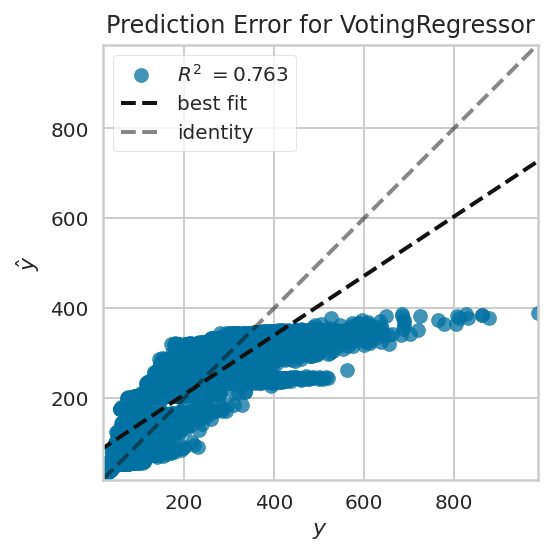

8.6s
learning


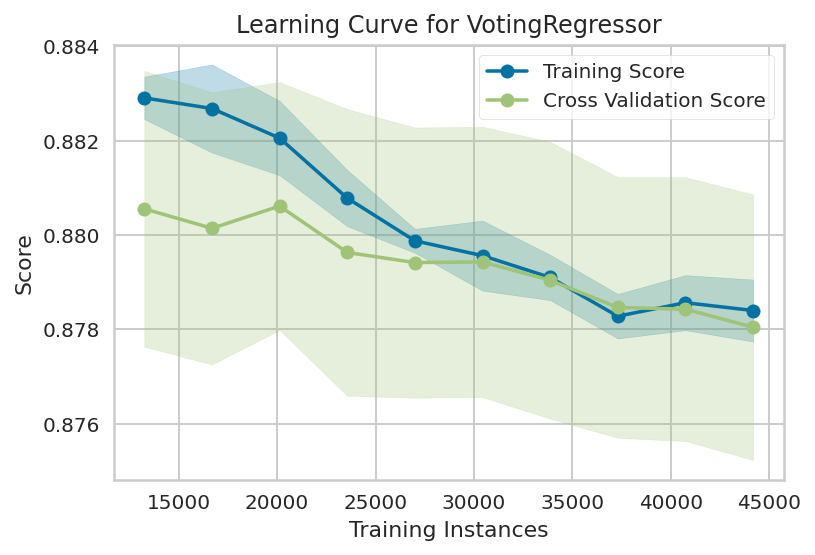

3106.5s
manifold


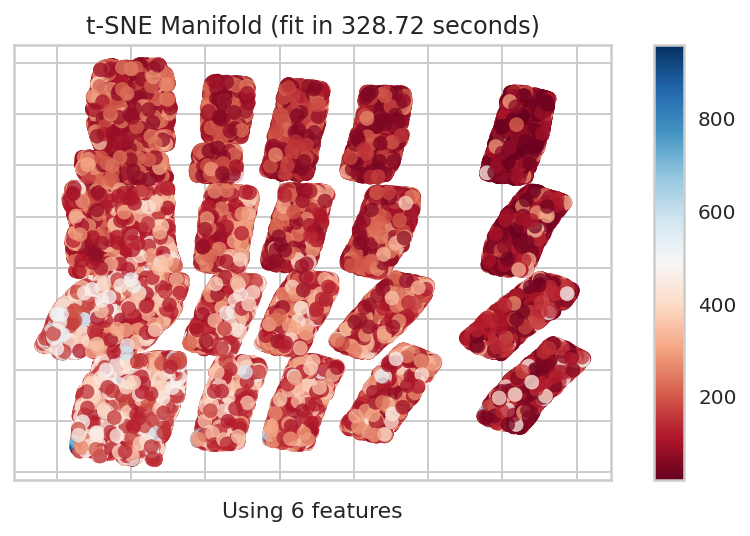

334.0s
CPU times: user 17min 41s, sys: 17.4 s, total: 17min 59s
Wall time: 57min 29s


In [35]:
%%time
import time

regression_plots = [
    'error',          # FAST = 4.5s
    'learning',       # SLOW = 107s
    'manifold',       # SLOW = 334.3s
]
categorical_plots = [
    'auc', 
    'threshold', 
    'pr', 
    'confusion_matrix',     
    'class_report', 
    'boundary', 
    'rfe',    
    'calibration', 
    'vc',             # SLOW 
    'dimension', 
    'feature', 
    'parameter'    
]
timings = {}
# plots = (fast_plots + slow_plots + categorical_plots) if os.environ.get('KAGGLE_KERNEL_RUN_TYPE') == 'Batch' else fast_plots
plots = regression_plots
for plot in plots:
    try:
        time_start = time.perf_counter()
        print(plot)
        plot_model(
            models['best'], 
            plot  = plot,
            scale = 2 if plot not in ['calibration'] else 1
        )
        time_taken = time.perf_counter() - time_start
        timings[plot] = time_taken
        print(f'{time_taken:.1f}s')        
    except: pass

In [36]:
# try:    pd.DataFrame([timings]).sort_values()
# except: pass

# evaluate_model()
> This function displays a user interface for analyzing performance of a trained model. It calls the plot_model function internally.

- https://pycaret.readthedocs.io/en/latest/api/clustering.html?highlight=evaluate_model#pycaret.clustering.evaluate_model

In [37]:
%%time
try: evaluate_model(models['best'])
except: pass

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

CPU times: user 1.31 s, sys: 149 ms, total: 1.46 s
Wall time: 1.22 s


# 10. Interpret Model

- https://pycaret.gitbook.io/docs/get-started/functions/analyze#interpret_model

> Interpreting complex models are of fundamental importance in machine learning. Model Interpretability helps debug the model by analyzing what the model really thinks is important. Interpreting models in PyCaret is as simple as writing interpret_model. The function takes trained model object and type of plot as string. Interpretations are implemented based on the SHAP (SHapley Additive exPlanations) and is only available for tree-based models.

In [38]:
# %%time
# # TypeError: This function only supports tree based models for binary classification: xgboost, dt, catboost, lightgbm, et, rf.
# try: 
#     interpret_model(models['catboost'])
#     interpret_model(models['catboost'],  plot='correlation')
#     interpret_model(models['catboost'],  plot='reason', observation=12)
# except: pass

# Predict Model

- https://pycaret.gitbook.io/docs/get-started/functions/deploy#predict_model

> Once a model is successfully deployed either on cloud using deploy_model or locally using save_model, it can be used to predict on unseen data using predict_model function. This functions takes a trained model object and the dataset to predict. It will automatically apply the entire transformation pipeline created during the experiment. For classification, predicted labels are created based on 50% probability, but if you choose to use a different threshold that you may have obtained using optimize_threshold, you can pass the probability_threshold parameter within predict_model. This function can also be used to generate predictions on hold-out / test set.

In [39]:
%%time
predict_train = predict_model(models['best'])
predict_train.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,45.9316,3755.1817,61.2795,0.7627,0.3214,0.3077


CPU times: user 3.79 s, sys: 488 ms, total: 4.27 s
Wall time: 3.47 s


,date_year,date_month,date_day,country,store,product,num_sold,Label
49089,2018.0,11.0,2.0,187.921248,1.0,178.659491,91,122.964194
49090,2019.0,5.0,11.0,115.112555,0.0,241.521329,162,216.517389
49091,2020.0,4.0,22.0,115.112555,1.0,241.521329,107,87.263713
49092,2017.0,10.0,28.0,238.618483,0.0,178.659491,374,325.564978
49093,2017.0,6.0,28.0,238.618483,1.0,133.663098,71,126.705145


In [40]:
%%time
# new_data = data.copy()
# new_data.drop(['charges'], axis=1, inplace=True)

test_df = pd.read_csv('../input/tabular-playground-series-sep-2022/test.csv', index_col=index_col)
test_df = enhance(test_df)

predict_test = predict_model(models['best'], data=test_df)
predict_test.head()

CPU times: user 3.29 s, sys: 478 ms, total: 3.77 s
Wall time: 3.02 s


,date_year,date_month,date_day,country,store,product,Label
row_id,,,,,,,
70128,2021.0,1.0,1.0,237.940623,0.0,223.243783,349.530239
70129,2021.0,1.0,1.0,237.940623,0.0,178.924424,300.305691
70130,2021.0,1.0,1.0,237.940623,0.0,134.030173,257.806885
70131,2021.0,1.0,1.0,237.940623,0.0,240.989562,359.617930
70132,2021.0,1.0,1.0,237.940623,1.0,223.243783,168.396867


# Submission

In [41]:
submission_df = pd.read_csv('../input/tabular-playground-series-sep-2022/sample_submission.csv', index_col=index_col)
submission_df[target_col] = predict_test['Label'].astype('int')
submission_df.to_csv('submission.csv')
!head submission.csv

row_id,num_sold
70128,349
70129,300
70130,257
70131,359
70132,168
70133,128
70134,99
70135,180
70136,335


# Save Model
> This function saves the transformation pipeline and trained model object into the current working directory as a pickle file for later use.

- https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=save_model#pycaret.classification.save_model
- https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=save_model#pycaret.classification.load_model

In [42]:
MODEL_NAME = 'model-tps-sept-2022'
save_model(models['best'], model_name=MODEL_NAME)
models['best'] = load_model(MODEL_NAME)
models['best']

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=Memory(location=/tmp/joblib),
         steps=[('date_feature_extractor',
                 TransformerWrapper(include=['date'],
                                    transformer=ExtractDateTimeFeatures())),
                ('numerical_imputer',
                 TransformerWrapper(include=[], transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['country', 'store', 'product'],
                                    transformer=SimpleImputer(fill_valu...
                                                                                             epsilon=1.1718715613965607),
                                                               random_state=42)),
                                             ('Huber Regressor_2',
                                              HuberRegressor(alpha=0.8123959882948841,
                                                             epsilon=1.1718715613965607)),
                      

# End
> Thank you. For more information / tutorials on PyCaret, please visit https://www.pycaret.org

# Further Reading

This notebook is part of a series exploring Tabular Data:

[Titanic](https://www.kaggle.com/competitions/titanic)
- [Profilereport EDA](https://www.kaggle.com/code/jamesmcguigan/titanic-profilereport-eda)

[Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic)
- [Profilereport EDA](https://www.kaggle.com/code/jamesmcguigan/titanic-profilereport-eda)
- 0.69932 - [XGBoost](https://www.kaggle.com/code/jamesmcguigan/spaceship-titanic-xgboost)

[Tabular Playground - Jan 2021](https://www.kaggle.com/c/tabular-playground-series-jan-2021)
- 0.72746 / 0.72935 - [scikit-learn Ensemble](https://www.kaggle.com/jamesmcguigan/tabular-playground-scikit-learn-ensemble)
- 0.71552 / 0.71659 - [Fast.ai Tabular Solver](https://www.kaggle.com/jamesmcguigan/fast-ai-tabular-solver)
- 0.70317 / 0.70426 - [XGBoost](https://www.kaggle.com/jamesmcguigan/tabular-playground-xgboost)
- 0.70011 / 0.70181 - [LightGBM](https://www.kaggle.com/jamesmcguigan/tabular-playground-lightgbm)

[Tabular Playground - Feb 2021](https://www.kaggle.com/c/tabular-playground-series-feb-2021)
- 0.84452 - [PyCaret2 AutoML Regression](https://www.kaggle.com/jamesmcguigan/tps-pycaret2-automl-regression)

[Tabular Playground - May 2022](https://www.kaggle.com/c/tabular-playground-series-feb-2021)
- 0.97134 - [LightGBM](https://www.kaggle.com/jamesmcguigan/tps-may-2022-lightgbm-regression)
- [LGBM + XGB + CB - Regression](https://www.kaggle.com/jamesmcguigan/tps-may-2022-lgbm-xgb-cb-regression)
- [LGBM + XGB + CB - Classification](https://www.kaggle.com/jamesmcguigan/tps-may-2022-lgbm-xgb-cb-classification)

[Tabular Playground - Aug 2022](https://www.kaggle.com/c/tabular-playground-series-aug-2022)
- 0.55525 - [PyCaret3 AutoML Classification](https://www.kaggle.com/code/jamesmcguigan/tps-pycaret3-automl-classification-aug-2022) [[Discussion](https://www.kaggle.com/competitions/tabular-playground-series-aug-2022/discussion/349818)]

[Tabular Playground - Sept 2022](https://www.kaggle.com/competitions/tabular-playground-series-sep-2022)
- [Profilereport EDA](https://www.kaggle.com/jamesmcguigan/tps-2022-09-profilereport-autoeda)
- [PyCaret3 AutoML Regression](https://www.kaggle.com/jamesmcguigan/tps-2022-09-pycaret3-automl-regression/)

If you found this notebook useful or learnt something new, then please upvote!